# 06. Using a Trajectory instead of HOOMD simulation

In this notebook we show how to use an existing trajectory, possible from another simulation engine, to do computations. Reading is done via `MDAnalysis`, which is required to run these examples.

In [1]:
import hoomd
import hoomd.htf as htf
import tensorflow as tf
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

## Build the computation graph

We demonstrate two types of computation. The first is to compute a potential energy function from the trajectory. This could then be trained by force matching (not shown). The second is that we compute RDFs from the trajectory.

In [2]:
graph = htf.graph_builder(128)
nlist = graph.nlist[:, :, :3]
r = tf.norm(nlist, axis=2)
# compute 1 / r while safely treating r = 0.
# pairwise energy. Double count -> divide by 2
inv_r6 = graph.safe_div(1., r**6)
p_energy = 4.0 / 2.0 * (inv_r6 * inv_r6 - inv_r6)
# sum over pairwise energy
energy = tf.reduce_sum(p_energy, axis=1)
forces = graph.compute_forces(energy)
# For reference, type indices in this case are: {C:0, H:1, N:2, O:3} 
# compute C-H RDF
rdf = graph.compute_rdf([3, 20], 'rdf-CH', 20, 0, 1)
graph.running_mean(rdf, 'avg-CH')
# compute O-H RDF
rdf2 = graph.compute_rdf([3, 20], 'rdf-OH', 20, 3, 1)
graph.running_mean(rdf2, 'avg-OH')
# save the graph
graph.save(force_tensor=forces, model_directory='traj_model')

Note: Backed-up traj_model previous model to traj_model/previous_model_0


## Run from trajectory

We load the trajectory with `MDAnalysis` and then call the `run_from_trajectory` command. It runs over the trajectory computing the graph and constructs neighborlists according to the r_cut. 

In [3]:
universe = mda.Universe('test_topol.pdb', 'test_traj.trr')
# load graph that calculates RDF
htf.run_from_trajectory('traj_model', universe, period=1, r_cut=25.)

## Analysis

Now we plot our RDFs. Note that the trajectory is very short to save on space in the repo, so the RDFs are under-sampled. 

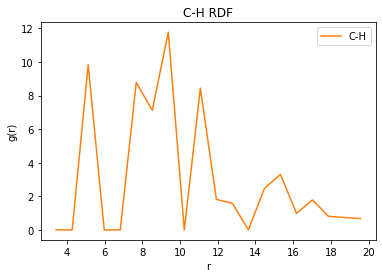

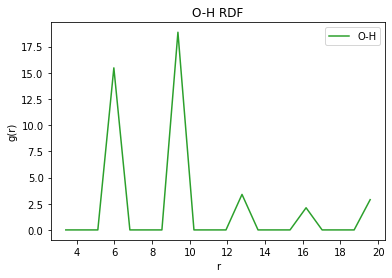

In [4]:
# get evaluated outnodes
variables = hoomd.htf.load_variables('traj_model', ['avg-CH', 'rdf-CH-r', 'avg-OH', 'rdf-OH-r'])

# Plot C-H rdf
r_CH = variables['rdf-CH-r']
# make it go to 1, since htf does not normalize the RDF
rdf_CH = variables['avg-CH']
rdf_CH /= np.mean(rdf_CH[-5:])

plt.figure()
plt.plot(r_CH, rdf_CH, label='C-H', color='C1')
plt.title(r'C-H RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()

# Plot O-H rdf
r_OH = variables['rdf-OH-r']
rdf_OH = variables['avg-OH']
rdf_OH /= np.mean(rdf_OH[-5:])

plt.figure()
plt.plot(r_OH, rdf_OH, label='O-H', color='C2')
plt.title(r'O-H RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()